# ABC calibration of $I_\text{Na}$ in Nygren model using unified dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant (fast+slow) [Sakakibara1992]
 - Recovery time constant (fast+slow) [Sakakibara1992]

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin,
                                        sakakibara_rec)
from experiments.ina_schneider import schneider_taum

Load the myokit modelfile for this channel.

In [5]:
modelfile = 'models/nygren_ina.mmt'

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [7]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                schneider_taum,
                                                sakakibara_inact,
                                                sakakibara_inact_kin,
                                                sakakibara_rec)
assert len(observations)==len(summary_statistics(model({})))

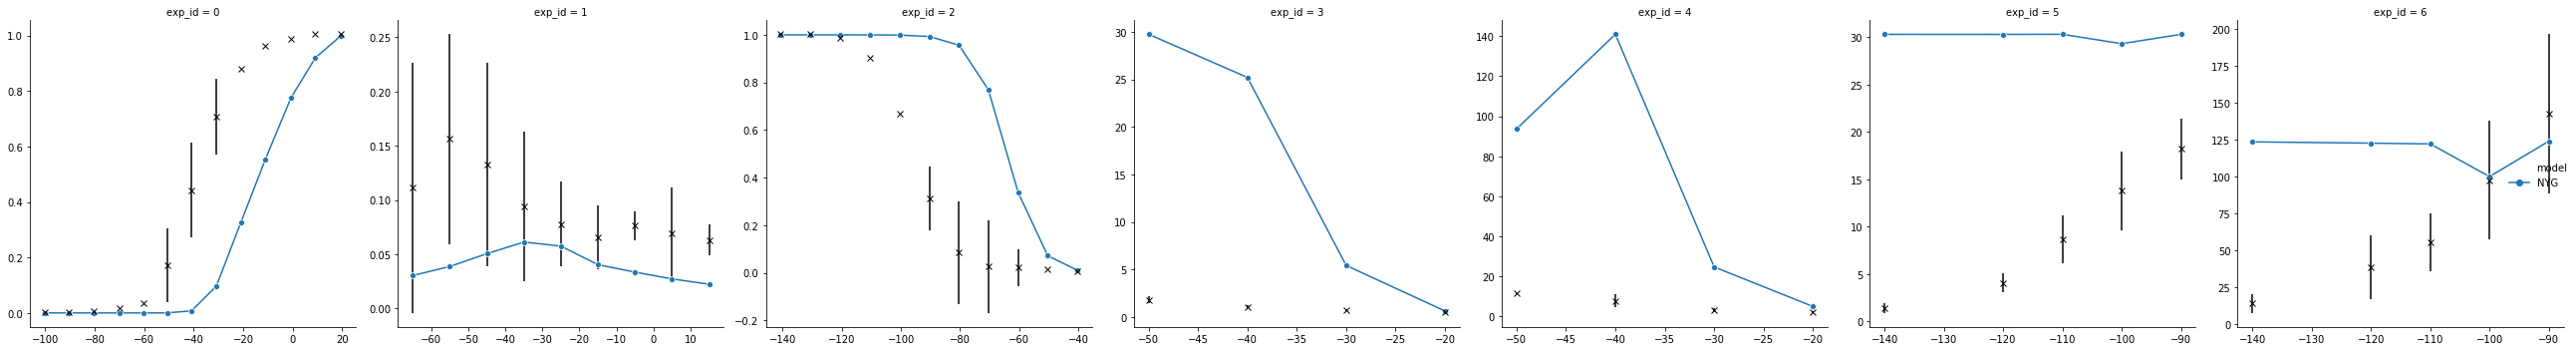

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin,
                     sakakibara_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [9]:
limits = {'ina.s1': (0, 1),
          'ina.r1': (0, 200),
          'ina.r2': (0, 50),
          'ina.q1': (0, 200),
          'ina.q2': (0, 50),
          'log_ina.r3': (-6, -3),
          'ina.r4': (0, 200),
          'ina.r5': (0, 50),
          'log_ina.r6': (-6, -3),
          'log_ina.q3': (-3., 0.),
          'ina.q4': (0, 200),
          'ina.q5': (0, 50),
          'log_ina.q6': (-5, -2),
          'log_ina.q7': (-3., 0.),
          'log_ina.q8': (-4, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [10]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

## Run ABC-SMC inference

Set-up path to results database.

In [10]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ina_unified.db"))

In [11]:
# Add logging for additional information during run.
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9521382851835398, '1': 0.9521382851835398, '2': 0.9521382851835398, '3': 0.9521382851835398, '4': 0.9521382851835398, '5': 0.3610802157587068, '6': 0.28091899218602906, '7': 0.34916236031070585, '8': 0.9521382851835398, '9': 0.9521382851835398, '10': 0.9521382851835398, '11': 0.9521382851835398, '12': 0.9521382851835398, '13': 0.09316342544404478, '14': 0.11125161472106906, '15': 0.11495918910006203, '16': 0.15597691589531334, '17': 0.27468055746289666, '18': 0.3630417376464485, '19': 0.8062952607338584, '20': 0.2544213362366676, '21': 0.7664744141929603, '22': 1.1252543370350925, '23': 1.1252543370350925, '24': 1.1252543370350925, '25': 1.1252543370350925, '26': 1.1252543370350925, '27': 0.42207751211772393, '28': 0.2622965124637598, '29': 0.2905205191839746, '30': 0.7247875556726021, '31': 1.1252543370350925, '32': 1.1252543370350925, '33': 0.808383669750957, '34': 1.591505349822196, '35': 2.2142683127961, '36': 3.0944494268465044, '37': 3.09444

In [15]:
# Convert observations to dictionary format for calibration
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-08 10:01:03.720695, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 6213
DEBUG:Epsilon:new eps, t=1, eps=15.353721955286717
INFO:ABC:t:1 eps:15.353721955286717
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 12148
DEBUG:Epsilon:new eps, t=2, eps=4.944026410807429
INFO:ABC:t:2 eps:4.944026410807429
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 19704
DEBUG:Epsilon:new eps, t=3, eps=3.4028564068925244
INFO:ABC:t:3 eps:3.4028564068925244
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 28778
DEBUG:Epsilon:new eps, t=4, eps=2.9805101136096868
INFO:ABC:t:4 eps:2.9805101136096868
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 40025
DEBUG:Epsilon:new eps, t=5, eps=2.6721188662

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

## Analysis of results

In [11]:
history = History('sqlite:///results/nygren/ina/unified/nygren_ina_unified.db')

In [12]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-08 10:01:03.720695, end_time=2019-10-09 04:42:35.446628)>]

In [13]:
df, w = history.get_distribution(m=0)

In [14]:
df.describe()

name,ina.q1,ina.q2,ina.q4,ina.q5,ina.r1,ina.r2,ina.r4,ina.r5,ina.s1,log_ina.q3,log_ina.q6,log_ina.q7,log_ina.q8,log_ina.r3,log_ina.r6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,92.858634,12.809199,53.938950,12.430058,46.391489,18.445925,109.216479,25.207404,0.459484,-2.054173,-3.786828,-2.038669,-3.452248,-4.520455,-4.325471
std,7.389962,6.437801,4.885144,2.474846,10.439024,9.427632,50.170957,13.070737,0.212763,0.441191,0.593289,0.446091,0.347896,0.766861,0.327711
min,70.816908,0.447443,37.484190,4.282045,1.661943,0.514322,0.023136,0.115273,0.031249,-2.819586,-4.997592,-2.861531,-3.998980,-5.998044,-5.991686
25%,88.315779,8.049941,50.569299,10.838399,39.848985,11.594457,71.103990,14.651906,0.288236,-2.468307,-4.215855,-2.482939,-3.713056,-5.117465,-4.477950
50%,93.100619,11.981837,54.101421,12.559515,46.839832,17.202855,111.404523,25.231453,0.458238,-2.306188,-3.808194,-1.806332,-3.534664,-4.515779,-4.278247
75%,97.120195,16.343929,57.520019,14.185484,53.998133,24.007198,148.118265,35.722920,0.619866,-1.607118,-3.380427,-1.609993,-3.238980,-3.931100,-4.100781
max,156.679220,47.124765,67.812861,20.800203,76.613925,49.649436,199.998079,49.906131,0.971433,-1.345580,-2.478499,-1.365536,-2.438193,-3.001034,-3.630032


### Plot summary statistics compared to calibrated model output.

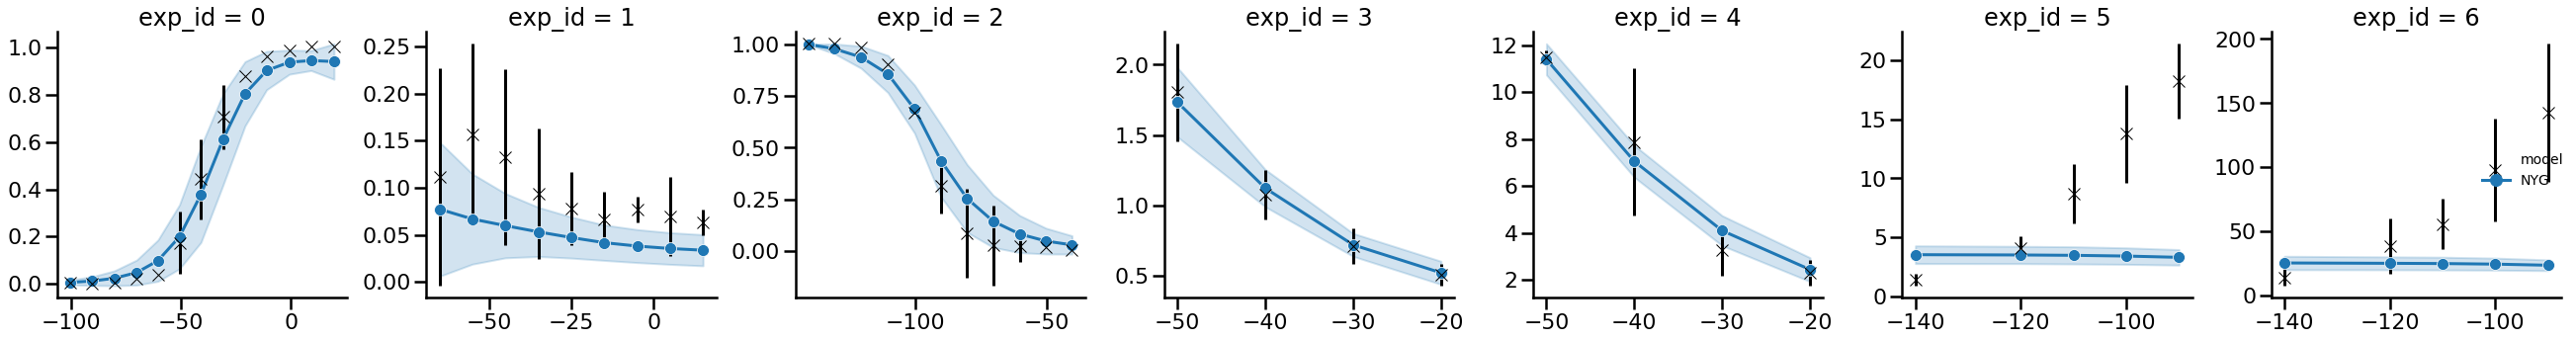

In [15]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin,
                     sakakibara_rec,
                     df=df, w=w)

plt.tight_layout()

In [22]:
#g.savefig('figures/ina/nyg_unified_sum_stats.pdf')

### Plot parameter distributions

In [16]:
m,_,_ = myokit.load(modelfile)

In [17]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

In [18]:
limits.keys()

dict_keys(['ina.s1', 'ina.r1', 'ina.r2', 'ina.q1', 'ina.q2', 'log_ina.r3', 'ina.r4', 'ina.r5', 'log_ina.r6', 'log_ina.q3', 'ina.q4', 'ina.q5', 'log_ina.q6', 'log_ina.q7', 'log_ina.q8'])

In [19]:
act_params = ['ina.s1','ina.r1','ina.r2','log_ina.r3','ina.r4','ina.r5','log_ina.r6']

In [26]:
df_act = df[act_params]
limits_act = dict([(key, limits[key]) for key in act_params])
originals_act = dict([(key, originals[key]) for key in act_params])

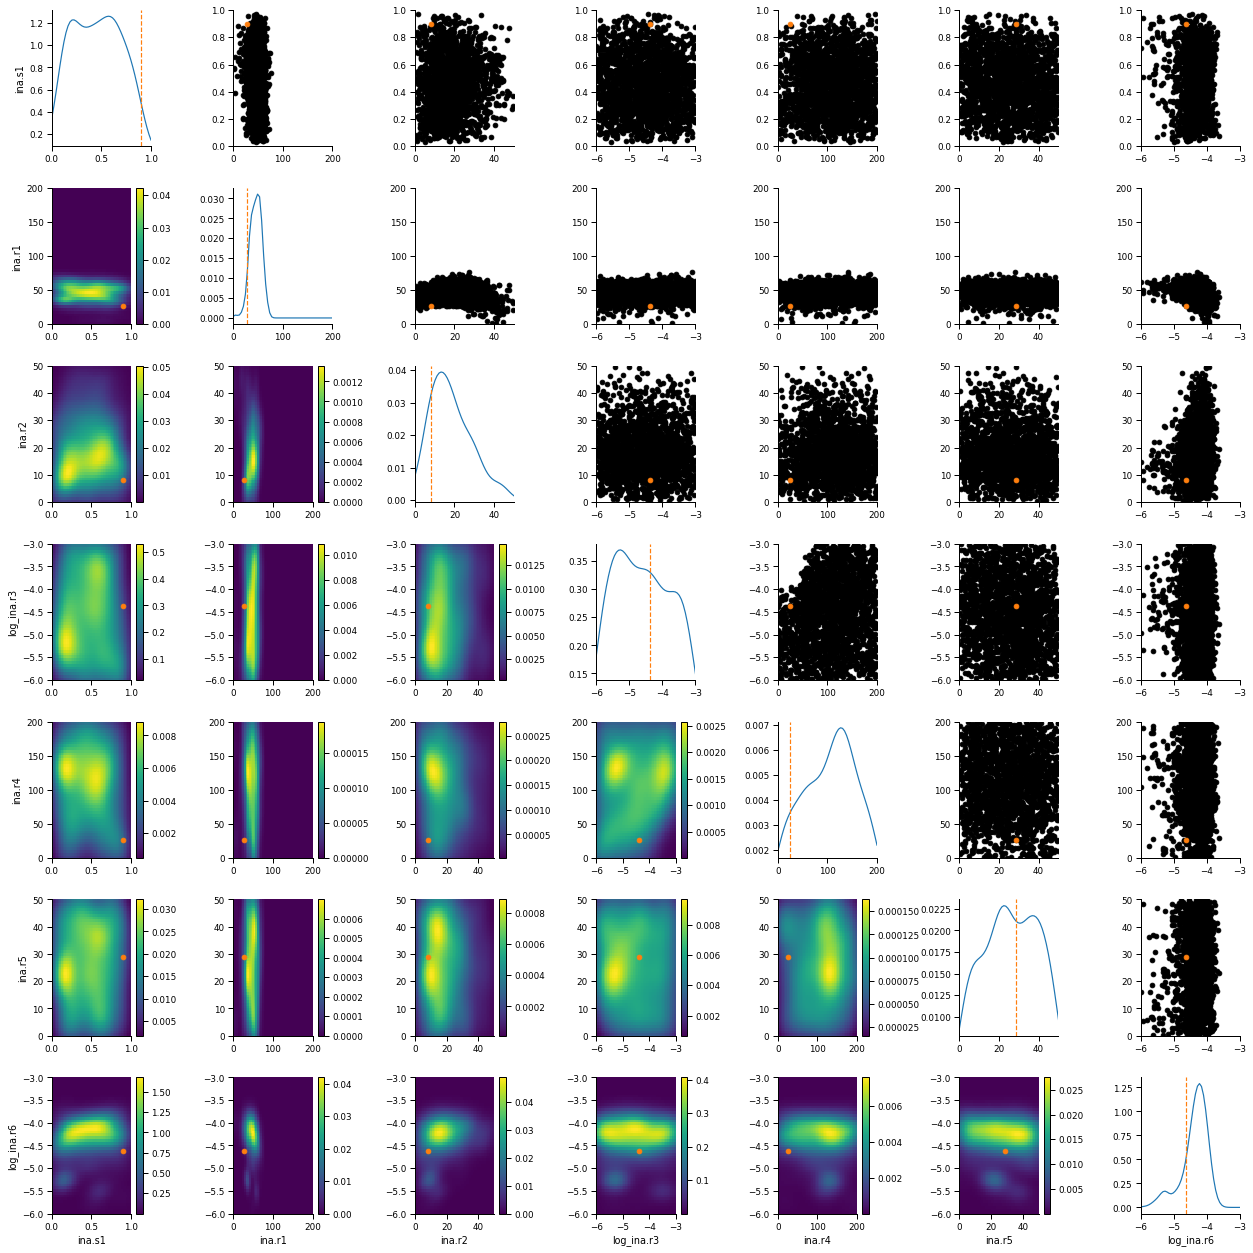

In [23]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df_act, w, limits=limits_act, refval=originals_act)

In [24]:
inact_params = ['ina.s1','ina.q1','ina.q2','log_ina.q3','ina.q4','ina.q5','log_ina.q6','log_ina.q7','log_ina.q8']

In [27]:
df_inact = df[inact_params]
limits_inact = dict([(key, limits[key]) for key in inact_params])
originals_inact = dict([(key, originals[key]) for key in inact_params])

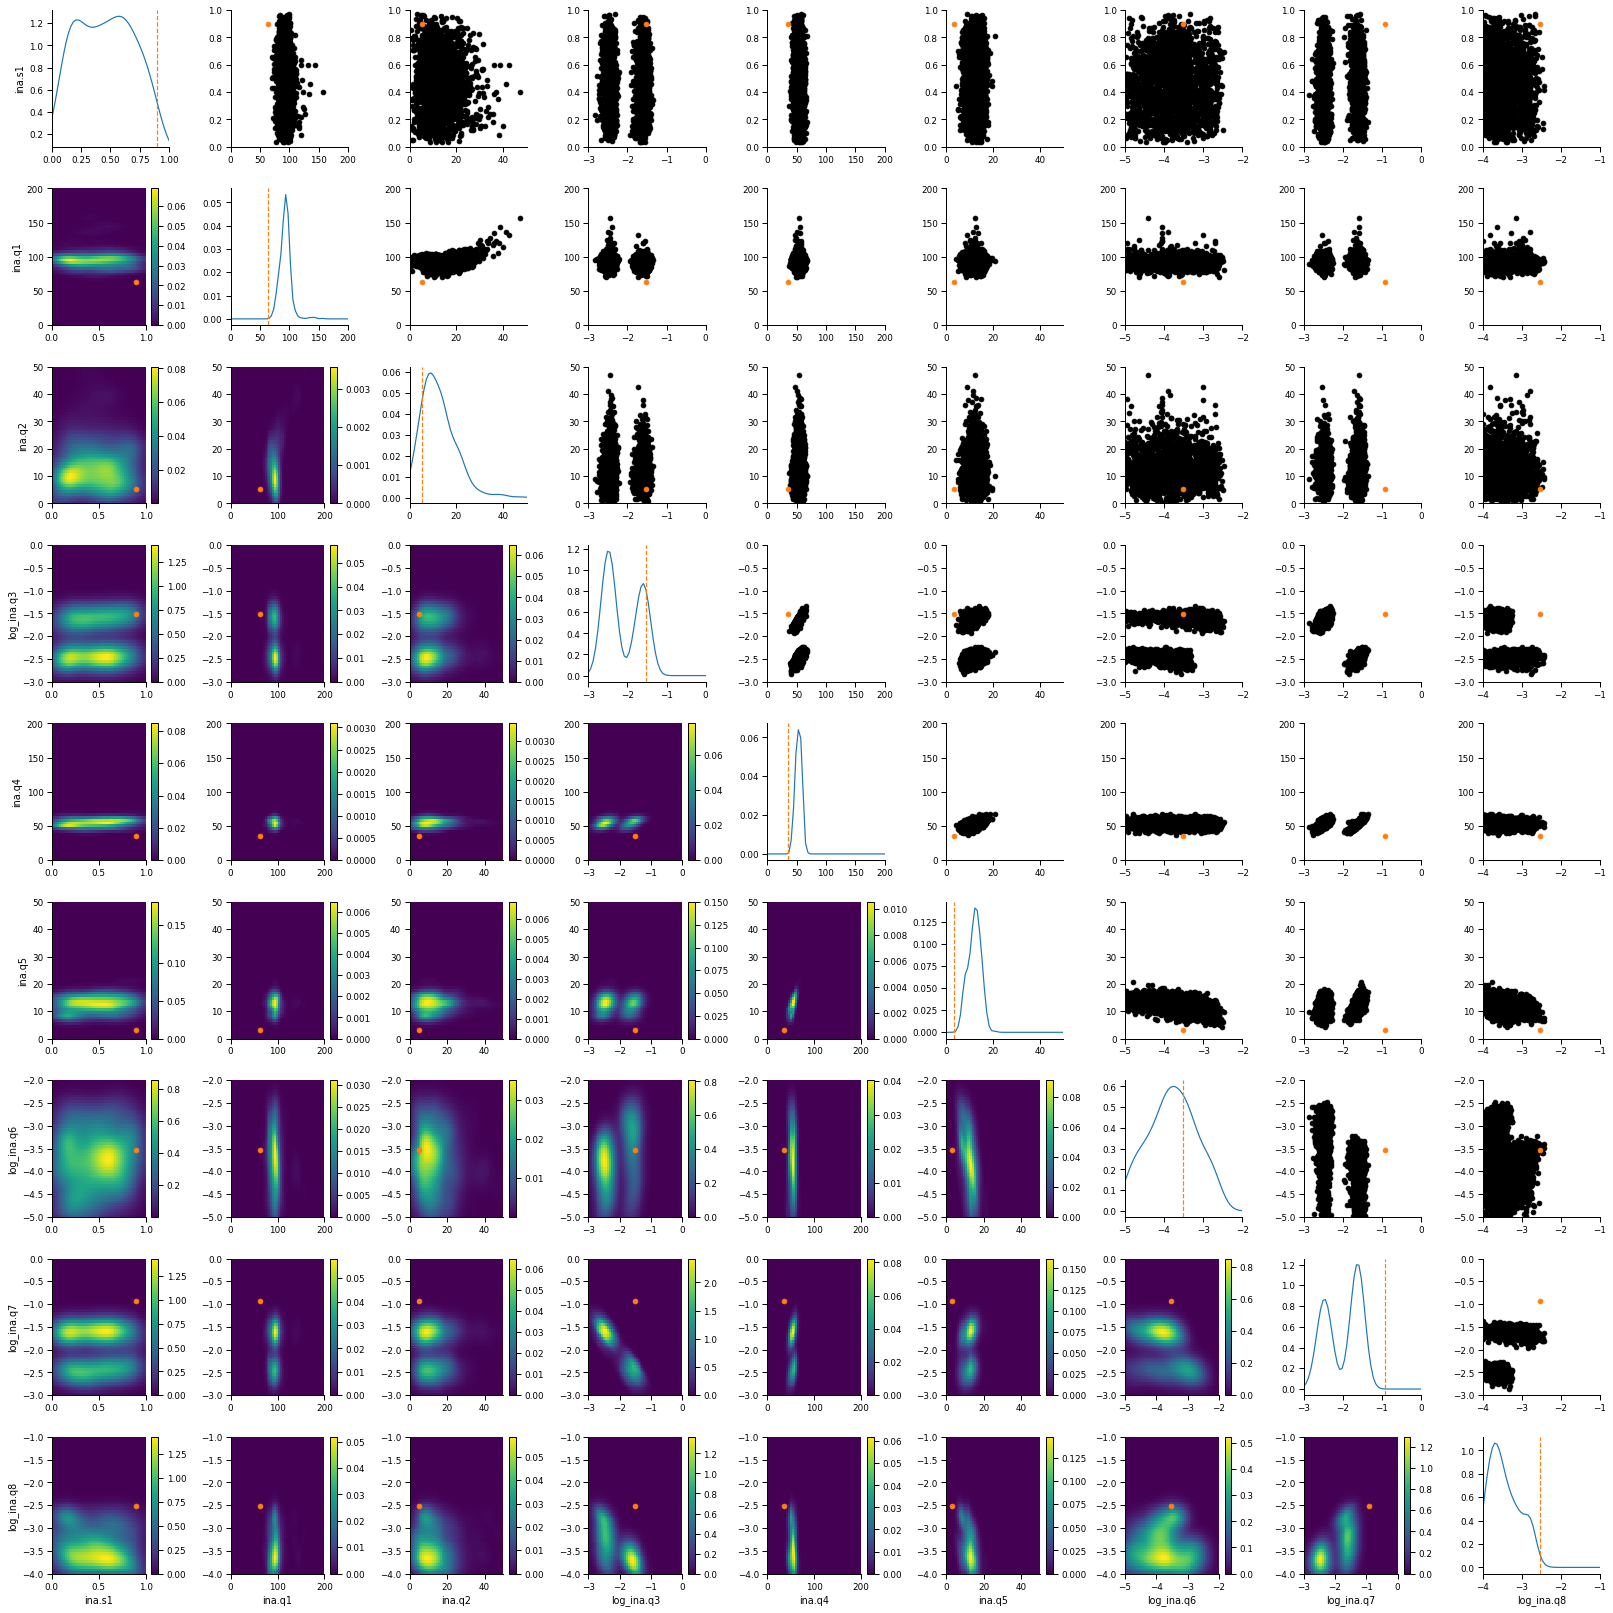

In [28]:
g = plot_kde_matrix_custom(df_inact, w, limits=limits_inact, refval=originals_inact)